# 1 Faces recognition with PCA and SVM
## 1.1 定义my_PCA

In [2]:
from time import time

#定义my_PCA类代替原PCA类，其中包括两种解法
#（1）协方差矩阵特征值分解
#（2）奇异值分解方法
class my_PCA(object):
    def __init__(self,n_components):
        self.num_components=n_components
    
    def fit_Cov(self,Train_data):#用特征值方法求主成分
        mean=np.mean(Train_data,axis=0)
        Train_data=Train_data-mean[np.newaxis,:]                        
        covariance=Train_data.T.dot(Train_data)/(np.shape(Train_data)[0]-1)        #求均值与协方差矩阵
        eig_values,eig_vectors=np.linalg.eig(covariance)    #调用numpy函数计算特征值及特征矩阵 
        tmp_index=np.argsort(-eig_values)                   #对特征值从大到小排序，返回其排序索引
        eig_values=eig_values[tmp_index]                    #特征值从大到小排序
        eig_vectors=eig_vectors[:,tmp_index]                #特征向量按其对应特征值从大到小排序
        self.proj_matrix=eig_vectors[:,:self.num_components]#挑选num_components个向量组成投影矩阵
        self.proj_matrix=self.proj_matrix/np.sqrt(eig_values[:self.num_components] + 1e-5)#白化操作
    
    def fit_SVD(self,Train_data):
        mean=np.mean(Train_data,axis=0)
        Train_data=Train_data-mean[np.newaxis,:]            #均值归一化为0
        eig_vectors,eig_values,v=np.linalg.svd(Train_data.T)#奇异值分解，得到奇异矩阵和特征值,特征值由大到小排列
        self.proj_matrix=eig_vectors[:,:self.num_components]#挑选num_components个向量组成投影矩阵
        self.proj_matrix=self.proj_matrix/np.sqrt(eig_values[:self.num_components] + 1e-5)#白化操作
        
    def transform(self,Raw_data):
        mean=np.mean(Raw_data,axis=0)
        Raw_data=Raw_data-mean[np.newaxis,:]                   #均值归一化为0
        new_data=Raw_data.dot(self.proj_matrix)                #将数据投影到新方向上
        
        return new_data

本题中使用numpy中的矩阵运算实现PCA功能。PCA即主成分分析，主要思想为选取矩阵最主要的N个正交分量，将矩阵投影到这些分量上从而实现数据的降维。实现PCA有两种方法：
+ 利用样本的协方差矩阵进行计算。对样本的协方差矩阵求特征值，根据特征值的大小选取前N个特征向量，得到投影矩阵。
+ 利用矩阵的奇异值分解。将样本矩阵奇异值分解后保留前N大的奇异值，而舍弃其他较小的奇异值。这些奇异值对应的左奇异向量即可组成降维投影矩阵。

在实现PCA的过程中注意到，sklearn中的PCA类有一个参数为“whitten”，通过指定该参数对样本做白归一化。该参数默认取值为True，因此在自己实现的PCA中使用白化操作，将每一个特征向量除以对应特征值的平方根，使得得到的降维数据在每一个维度上方差相等。（由于具体归一化方法与sklearn中PCA函数略有差异，因此计算结果略有不同，不影响原理及分类性能）

##  1.2 对比特征值分解与SVD

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

lfw_people = np.load('ex1.npz')
X = lfw_people['X']
y = lfw_people['y']
print('Number of samples:',np.shape(y)[0])
print('Dimension of samples:',np.shape(X)[-1])

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#下面比较两种方法计算复杂度，由于全部数据维度较高，此处仅用前3000维做计算
#奇异值分解
t0 = time()
pca = my_PCA(n_components=150)
pca.fit_SVD(X_train[:,0:3000])
print("Singular value decomposition:done in %0.3fs" % (time() - t0))

#协方差矩阵特征值分解
t0 = time()
pca = my_PCA(n_components=150)
pca.fit_Cov(X_train[:,0:3000])
print("Eigenvalue decomposition:done in %0.3fs" % (time() - t0))

Number of samples: 966
Dimension of samples: 11750
Singular value decomposition:done in 1.887s
Eigenvalue decomposition:done in 18.262s


从上面的对比中可以看出，计算协方差矩阵特征值的方法消耗的时间远多于计算样本矩阵奇异值分解。这是由于特征值的计算为$O(n^3)$复杂的运算，且没有特别有效的快速算法。而奇异值分解有有效的快速算法，能够很快得到答案，这一差距在矩阵维度很高的时候更加突出。因此，下面均使用奇异值分解的方法进行PCA（sklearn中使用的也是这种方法）。

## 1.3 研究n_components的选取对分类结果影响

Text(0.5, 1.0, 'Effect of Number of Components on Test Accurancy')

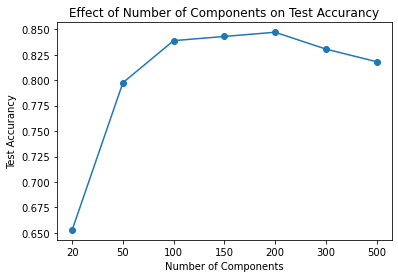

In [18]:
import matplotlib.pyplot as plt

# 编写函数探究投影到不同数量的特征对分类结果的影响
def search_components(num):
    pca_temp = my_PCA(n_components=num)
    pca_temp.fit_SVD(X_train)#用奇异值分解的方法计算PCA投影矩阵

    X_train_pca = pca_temp.transform(X_train)#将训练集、测试集样本投影降维
    X_test_pca = pca_temp.transform(X_test)

    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)#GridSearch得到SVM最佳参数
    clf = clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)

    return np.sum(y_test==y_pred)/len(y_test)#预测并返回准确率

# 探究投影到不同数量的特征对分类结果的影响
LIST=[20,50,100,150,200,300,500]
record=list()
for i in LIST:
    record.append(search_components(i))

plt.figure()
plt.plot(range(len(LIST)),record,marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Test Accurancy')
plt.xticks(range(7),LIST)
plt.title('Effect of Number of Components on Test Accurancy')

由上面的研究可以发现，当选取的特征值很少时，数据压缩过度，不能很好地进行分类；当特征值选取很多时，数据压缩后维度仍然很高，不能有效提取分类特征。因此存在一个最佳的特征值选取数目，从上图中可以得到，选取200个特征值时分类效果最好，因此下面的操作中即选取200个特征值进行降维、分类。

##  1.3 SVM训练、验证与测试

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

n_components = 200#根据上一节探究结果选取最佳主成分数量

#利用my_PCA中的SVD方法降维
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = my_PCA(n_components=n_components)
pca.fit_SVD(X_train)
print("Done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# 通过GridSearch的办法找到SVM的最佳参数
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

# 通过混淆矩阵和测试集准确率评价分类效果
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Done in %0.3fs" % (time() - t0))
print(confusion_matrix(y_test, y_pred, labels=range(7)))
print('Test accurancy=',np.sum(y_test==y_pred)/len(y_test))

Extracting the top 200 eigenfaces from 724 faces
Done in 27.326s
Fitting the classifier to the training set
Done in 26.557s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
Done in 0.035s
[[11  2  1  0  0  0  1]
 [ 0 41  1  4  0  0  0]
 [ 0  1 16  4  0  0  0]
 [ 0  3  0 89  0  0  0]
 [ 0  0  0  6 13  0  3]
 [ 0  0  0  4  1 12  2]
 [ 0  0  1  3  0  0 23]]
Test accurancy= 0.8471074380165289


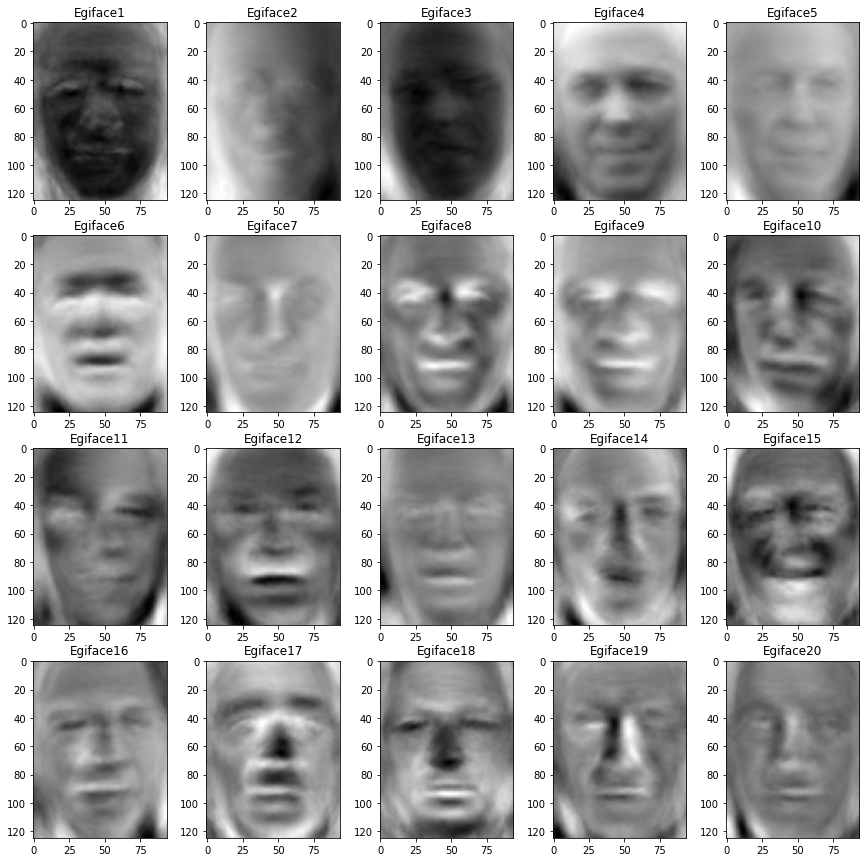

In [21]:
#画出前20个“特征脸”
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.reshape(pca.proj_matrix[:,i],(125,94)),cmap='gray')
    plt.title('Egiface{}'.format(i+1))

   这一节中利用划分出的训练集和测试集训练得到了支持向量机模型。在最优的正则化和核函数参数下，测试集分类准确率为84.7%。混淆矩阵中主对角线上数值远大于其他数值，意味着大部分样本都被正确分类，模型分类性能良好。画出前20个最大特征值对应的特征向量可视化结果，即得到了20个“特征脸”，数据降维的原理正是将高维样本投影到这些“特征脸”上，只记录样本在每个“特征脸”上的线性组合系数。
##  1.4 给出test上的分类结果

In [23]:
test_data=np.load('test.npz')['X']
test_data_pca=pca.transform(test_data)#投影降维
result=clf.predict(test_data_pca)#分类推断
np.savetxt("output.txt",result.reshape(1, result.shape[0]),fmt='%d',delimiter=' ')

完成上述过程后，得到了PCA模型和SVM模型，此处即可利用这两个模型，对未知测试集进行投影降维、分类推断。结果保存在output.txt中